# Model Training 
This is the code is the training code for ML-based approach in intrusion detection. It was modified from notebook provided by "[**Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection**](https://arxiv.org/pdf/2409.03141)".

Please also cite:
L. Yang and A. Shami, “Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection,” in Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber ’24), 2024 ACM SIGSAC Conference on Computer and Communications Security (CCS’24), 2024, pp. 1–11. doi: 10.1145/3689933.3690833.

```
@INPROCEEDINGS{3690833,
  author={Yang, Li and Shami, Abdallah},
  title = {Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection},
  booktitle = {Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber '24), ACM Conference on Computer and Communications Security (CCS) 2024},
  year = {2024},
  address = {Salt Lake City, UT, USA},
  pages = {1-11},
  doi = {10.1145/3689933.3690833}
}
```

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
import time

In [3]:
CHECKPOINT_OUTPUT = "./models"

## Dataset 1: CICIDS2017
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  

Due to the large size of this dataset and the file size limit of GitHub, the sampled subset of CICIDS2017 is used. The subsets are in the "Data" folder.  PS: The results might be different from the paper due to the size difference of the dataset.

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.


### Load data

In [4]:
# Read the dataset
df = pd.read_csv('../../datasets/output/train_final.csv', parse_dates=['Timestamp'])

In [5]:
df = df.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Old Index', 'Fwd TCP Retrans. Count', 'Bwd TCP Retrans. Count', 'Total TCP Retrans. Count', 'Total Connection Flow Time'], axis=1)

In [6]:
df['Label'].value_counts()

Label
Benign       484847
Portscan     127232
Slowloris      4565
Name: count, dtype: int64

In [7]:
df['Label'] = df['Label'].map({
    "Slowloris": "Slowloris",
    "Portscan": "Not Slowloris",
    "Benign": "Not Slowloris"
})

In [8]:
df['Label'].value_counts()

Label
Not Slowloris    612079
Slowloris          4565
Name: count, dtype: int64

### Data pre-processing

In [9]:
# Encode the dataset
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

In [10]:
df['Label'].value_counts()

Label
0    612079
1      4565
Name: count, dtype: int64

In [11]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

array([0, 1])

In [12]:
df.isnull().any().any()

False

In [13]:
df.isna().any().any()

False

In [14]:
# Split the dataset into training and testing
X = df.drop(['Label'],axis=1) 
y = df['Label'].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = 0.75, test_size = 0.25, random_state = 0, stratify = y)
# 0.75 & 0.25 means 60% train and 20% validation FROM WHOLE DATASET (counting test)

In [15]:
labelencoder.classes_

array(['Not Slowloris', 'Slowloris'], dtype='<U13')

## Data Balancing by Proposed TVAE-based Method

In [16]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [17]:
y_train = pd.Series(y_train)
y_val = pd.Series(y_val)

In [18]:
from sdv.single_table import TVAESynthesizer
# Identify the average number of samples per class
average_samples = y_train.value_counts().mean()

# Identify minority classes with less than half the average number of samples
minority_classes = y_train.value_counts()
minority_classes = minority_classes[minority_classes < average_samples / 2].index.tolist()

# Prepare an empty DataFrame to collect synthetic data
synthetic_data = pd.DataFrame()

In [19]:
y_train.index = X_train.index

In [20]:
# Generating synthetic samples for each minority class using TVAE
for cls in minority_classes:
    cls_samples = X_train[y_train == cls]
    num_samples_needed = int(average_samples - len(cls_samples))
    
    # Initialize the TVAE model with detected metadata
    tvaegan = TVAESynthesizer(metadata=metadata, cuda=True, verbose=True)
    
    # Fit the TVAE model on the minority class samples
    tvaegan.fit(cls_samples.assign(Label=y_train[y_train == cls]))  # add Label temporarily for TVAE training
    
    # Generate synthetic instances to match the average class sample size
    new_samples = tvaegan.sample(num_samples_needed)
    
    # Append the new synthetic instances to the synthetic data list
    synthetic_data = pd.concat([synthetic_data, new_samples], ignore_index=True)

Loss: -457.167: 100%|██████████| 300/300 [01:04<00:00,  4.63it/s]


In [21]:
# Concatenate the original and synthetic data to form a balanced dataset
balanced_data = pd.concat([X_train.assign(Label=y_train), synthetic_data], ignore_index=True)

# Display the new distribution of labels in the balanced dataset
print(balanced_data['Label'].value_counts())

# Prepare the balanced dataset for model training
X_train_balanced = balanced_data.drop(['Label'], axis=1)
y_train_balanced = balanced_data['Label']

Label
0    459059
1    231241
Name: count, dtype: int64


In [22]:
X_val.reset_index().to_csv(f"{CHECKPOINT_OUTPUT}/X_val.csv", index=False)
X_train_balanced.to_csv(f"{CHECKPOINT_OUTPUT}/X_train_balanced.csv", index=False)
y_val.reset_index().to_csv(f"{CHECKPOINT_OUTPUT}/y_val.csv", index=False)
y_train_balanced.to_csv(f"{CHECKPOINT_OUTPUT}/y_train_balanced.csv", index=False)

In [4]:
X_val = pd.read_csv(f"{CHECKPOINT_OUTPUT}/X_val.csv", index_col=0)
X_train_balanced = pd.read_csv(f"{CHECKPOINT_OUTPUT}/X_train_balanced.csv")
y_val = pd.read_csv(f"{CHECKPOINT_OUTPUT}/y_val.csv", index_col=0)['0']
y_train_balanced = pd.read_csv(f"{CHECKPOINT_OUTPUT}/y_train_balanced.csv")['Label']

## Machine learning model training (for feature selection)

### Training six base learners (for comparison purposes): 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


In [ ]:
# from sklearn.metrics import f1_score, make_scorer
# from sklearn.model_selection import cross_val_score, StratifiedKFold

# def cross_val_f1_macro(clf, X, y, n_jobs):
#     scorer = make_scorer(f1_score, average='macro')
#     return cross_val_score(clf, X, y, n_jobs=n_jobs, scoring=scorer, cv=StratifiedKFold(n_splits=3))

#### DT

Training time:  27.994118690490723
Prediction time per sample:  0.00024401247120533942
Cross-Validation scores:  [0.9989068  0.99992684 0.99990734]
Mean of Cross-Validation scores:  0.9995803252976597
Accuracy of DT: 0.9999610796504953
Precision of DT: 0.9982436835437918
Recall of DT: 0.9991105056237888
F1-score of DT: 0.9986767121819253
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



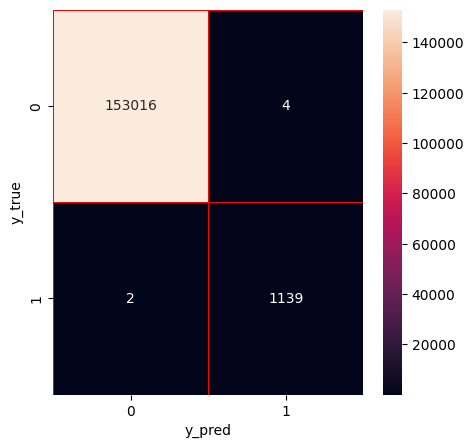

In [ ]:
# %%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_f1_macro(dt, X_train_balanced, y_train_balanced, 4)

# calculate the training time
start = time.time()
dt.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val)*1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### RF

Training time:  33.602386236190796
Prediction time:  0.0008857279366198705 ms
Cross-Validation scores:  [0.99941451 0.99999512 0.99999512]
Mean of Cross-Validation scores:  0.9998015868568043
Accuracy of RF: 0.9999805398252476
Precision of RF: 0.9995548684580273
Recall of RF: 0.9991203082639665
F1-score of RF: 0.9993374923829057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



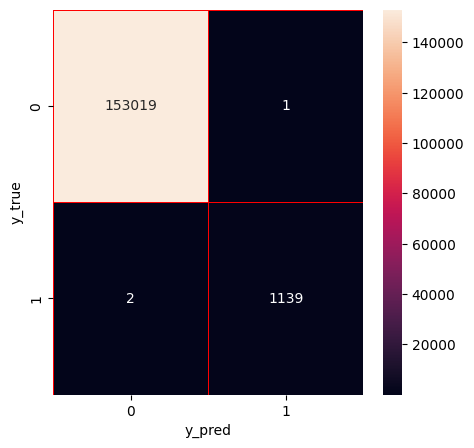

In [9]:
# %%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_f1_macro(rf, X_train_balanced, y_train_balanced, 8)

# calculate the training time
start = time.time()
rf.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### ET

Training time:  16.184823751449585
Prediction time:  0.001424475267564575 ms
Cross-Validation scores:  [0.99994147 1.         0.99999512]
Mean of Cross-Validation scores:  0.9999788651668441
Accuracy of ET: 0.9999740531003302
Precision of ET: 0.9991170407172405
Recall of ET: 0.9991170407172405
F1-score of ET: 0.9991170407172405
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



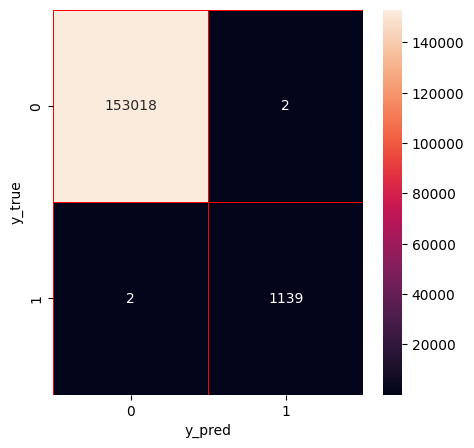

In [10]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=8)
et_scores = cross_val_f1_macro(et, X_train_balanced, y_train_balanced, 8)

# calculate the training time
start = time.time()
et.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val) * 1000, 'ms')


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### XGBoost

Training time:  2.580573081970215
Prediction time per sample:  0.0003255314241470261
Cross-Validation scores:  [0.99745966 0.99999512 0.99999025]
Mean of Cross-Validation scores:  0.9991483431437099
Accuracy of XGBoost: 0.9999805398252476
Precision of XGBoost: 0.9995548684580273
Recall of XGBoost: 0.9991203082639665
F1-score of XGBoost: 0.9993374923829057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



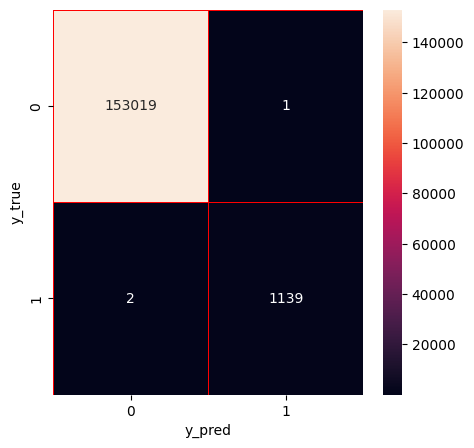

In [11]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=8)
xg_scores = cross_val_f1_macro(xg, X_train_balanced, y_train_balanced, 8)

# calculate the training time
start = time.time()
xg.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154160, number of negative: 306040
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 154161, number of negative: 306039
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16265
[LightGBM] [Info] Number of data points in the train set: 460200, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334985 -> initscore=-0.685725
[LightGBM] [Info] Start training from score -0.685725
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

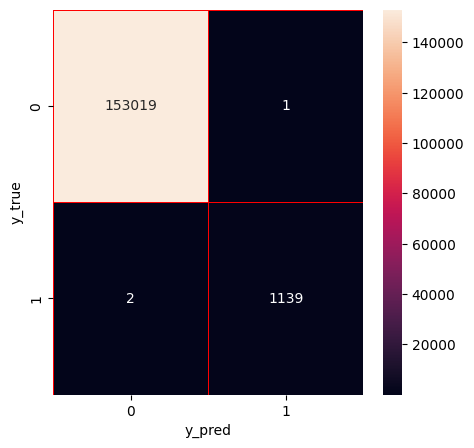

In [12]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_f1_macro(lgbm, X_train_balanced, y_train_balanced, 8)

# calculate the training time
start = time.time()
lgbm.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)



y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### Catboost

Training time:  38.15786862373352
Prediction time per sample:  0.0002076591320316098
Cross-Validation scores:  [0.99933643 0.99997561 0.99999025]
Mean of Cross-Validation scores:  0.9997674296942863
Accuracy of CatBoost: 0.9999545929255778
Precision of CatBoost: 0.9982388838106468
Recall of CatBoost: 0.9986722935291349
F1-score of CatBoost: 0.9984554930278462
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



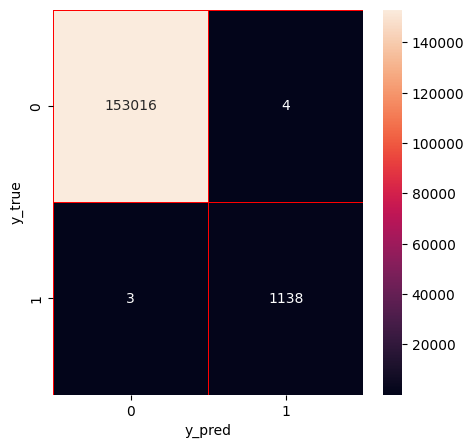

In [13]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False, thread_count=8)
cat_scores = cross_val_f1_macro(cat, X_train_balanced, y_train_balanced, 8)


# calculate the training time
start = time.time()
cat.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [14]:
# record the results
dt_train=dt.predict(X_train_balanced)
dt_val=dt.predict(X_val)
dt_prob_train=dt.predict_proba(X_train_balanced)
dt_prob_val=dt.predict_proba(X_val)

rf_train=rf.predict(X_train_balanced)
rf_val=rf.predict(X_val)
rf_prob_train=rf.predict_proba(X_train_balanced)
rf_prob_val=rf.predict_proba(X_val)

et_train=et.predict(X_train_balanced)
et_val=et.predict(X_val)
et_prob_train=et.predict_proba(X_train_balanced)
et_prob_val=et.predict_proba(X_val)

xg_train=xg.predict(X_train_balanced)
xg_val=xg.predict(X_val)
xg_prob_train=xg.predict_proba(X_train_balanced)
xg_prob_val=xg.predict_proba(X_val)

lgbm_train=lgbm.predict(X_train_balanced)
lgbm_val=lgbm.predict(X_val)
lgbm_prob_train=lgbm.predict_proba(X_train_balanced)
lgbm_prob_val=lgbm.predict_proba(X_val)

cat_train=cat.predict(X_train_balanced)
cat_val=cat.predict(X_val)
cat_prob_train=cat.predict_proba(X_train_balanced)
cat_prob_val=cat.predict_proba(X_val)

In [15]:
MODEL_OUTPUT_PREFS = "./models/prefs"

In [16]:
import joblib

joblib.dump(dt, f"{MODEL_OUTPUT_PREFS}/dt.pkl")
joblib.dump(rf, f"{MODEL_OUTPUT_PREFS}/rf.pkl")
joblib.dump(et, f"{MODEL_OUTPUT_PREFS}/et.pkl")
joblib.dump(xg, f"{MODEL_OUTPUT_PREFS}/xg.pkl")
joblib.dump(lgbm, f"{MODEL_OUTPUT_PREFS}/lgbm.pkl")
joblib.dump(cat, f"{MODEL_OUTPUT_PREFS}/cat.pkl")

['./models/prefs/cat.pkl']

In [17]:
import gc
gc.collect()

5262

## Model selection

In [18]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)
}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [19]:
top_3_models

['et', 'rf', 'cat']

## Model Ensemble

In [20]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)

dt_val=dt_val.reshape(-1, 1)
et_val=et_val.reshape(-1, 1)
rf_val=rf_val.reshape(-1, 1)
xg_val=xg_val.reshape(-1, 1)
lgbm_val=lgbm_val.reshape(-1, 1)
cat_val=cat_val.reshape(-1, 1)

Training time of Stacking: 0.31796741485595703
Testing time of Stacking: 2.590790172034026e-05
Accuracy of Stacking: 0.9999740531003302
Precision of Stacking: 0.9991170407172405
Recall of Stacking: 0.9991170407172405
F1-score of Stacking: 0.9991170407172405
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



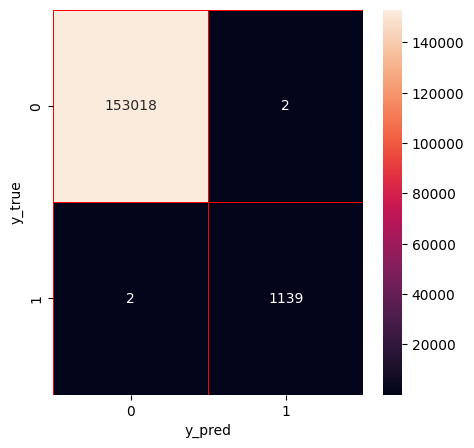

In [21]:
from sklearn.metrics import accuracy_score

# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_val_predictions = [globals()[model.lower() + '_val'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train = np.concatenate(top_3_train_predictions, axis=1)
x_val = np.concatenate(top_3_val_predictions, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0, n_jobs=8).fit(x_train, y_train_balanced)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Training time of Stacking: 0.3906593322753906
Testing time of Stacking: 3.7149815378718564e-05
Accuracy of Stacking: 0.9971328675864842
Precision of Stacking: 0.8606647571032913
Recall of Stacking: 0.9976858552512884
F1-score of Stacking: 0.9180268371934739
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       0.72      1.00      0.84      1141

    accuracy                           1.00    154161
   macro avg       0.86      1.00      0.92    154161
weighted avg       1.00      1.00      1.00    154161



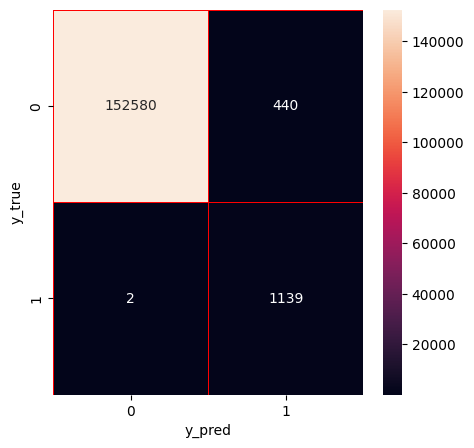

In [22]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_val_proba = [globals()[model.lower() + '_prob_val'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_val_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train_balanced)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Training time of Stacking: 0.4412574768066406
Testing time of Stacking: 2.748848168441546e-05
Accuracy of Stacking: 0.9999740531003302
Precision of Stacking: 0.9991170407172405
Recall of Stacking: 0.9991170407172405
F1-score of Stacking: 0.9991170407172405
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



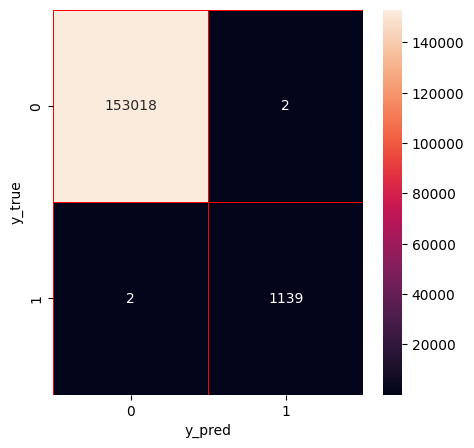

In [23]:
# Ensemble method 3: hybrid stacking

# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_val_predictions = [globals()[model.lower() + '_val'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_val_proba = [globals()[model.lower() + '_prob_val'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_val_predictions + top_3_val_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train_balanced)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Automated Feature Selection

In [24]:
# Save the feature importance lists generated by base ML algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xg_feature = xg.feature_importances_
lgbm_feature = lgbm.feature_importances_
cat_feature = cat.feature_importances_

In [25]:
lgbm_feature = lgbm_feature/sum(lgbm_feature)
cat_feature = cat_feature/sum(cat_feature)

In [26]:
# Get the feature importances of the top-3 models
top_3_importances = [globals()[model.lower() + '_feature'] for model in top_3_models]

# Calculate the average importance of each feature
avg_feature = np.mean(top_3_importances, axis=0)

feature=X_train_balanced.columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)


Features sorted by their score:
[(0.0923, 'Fwd Seg Size Min'), (0.0622, 'Fwd IAT Min'), (0.0384, 'Fwd Packets/s'), (0.0357, 'Flow IAT Mean'), (0.0354, 'Protocol'), (0.0336, 'Fwd Packet Length Min'), (0.0321, 'Bwd RST Flags'), (0.0291, 'Bwd IAT Mean'), (0.0281, 'Total Bwd packets'), (0.0281, 'Bwd IAT Min'), (0.0267, 'FIN Flag Count'), (0.0253, 'Bwd Packet Length Mean'), (0.0236, 'Fwd IAT Total'), (0.0233, 'Total Length of Bwd Packet'), (0.0231, 'Packet Length Mean'), (0.0225, 'Flow Packets/s'), (0.0209, 'Bwd Packet Length Max'), (0.0196, 'Flow IAT Max'), (0.0193, 'Fwd IAT Max'), (0.0193, 'Bwd IAT Max'), (0.0191, 'Flow Duration'), (0.0184, 'SYN Flag Count'), (0.0184, 'RST Flag Count'), (0.0157, 'Bwd Act Data Pkts'), (0.0154, 'FWD Init Win Bytes'), (0.0152, 'Bwd Packets/s'), (0.0143, 'Average Packet Size'), (0.013, 'Fwd IAT Mean'), (0.013, 'Bwd Segment Size Avg'), (0.0125, 'Bwd IAT Total'), (0.0124, 'Bwd Packet Length Min'), (0.0123, 'Bwd Init Win Bytes'), (0.0122, 'Fwd Bulk Rate Avg'), (

In [27]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [28]:
print(fs)

['Fwd Seg Size Min', 'Fwd IAT Min', 'Fwd Packets/s', 'Flow IAT Mean', 'Protocol', 'Fwd Packet Length Min', 'Bwd RST Flags', 'Bwd IAT Mean', 'Total Bwd packets', 'Bwd IAT Min', 'FIN Flag Count', 'Bwd Packet Length Mean', 'Fwd IAT Total', 'Total Length of Bwd Packet', 'Packet Length Mean', 'Flow Packets/s', 'Bwd Packet Length Max', 'Flow IAT Max', 'Fwd IAT Max', 'Bwd IAT Max', 'Flow Duration', 'SYN Flag Count', 'RST Flag Count', 'Bwd Act Data Pkts', 'FWD Init Win Bytes', 'Bwd Packets/s', 'Average Packet Size', 'Fwd IAT Mean', 'Bwd Segment Size Avg', 'Bwd IAT Total', 'Bwd Packet Length Min', 'Bwd Init Win Bytes', 'Fwd Bulk Rate Avg', 'Flow IAT Std', 'Down/Up Ratio', 'Packet Length Std', 'Bwd Packet Length Std', 'Packet Length Max', 'Idle Max', 'Fwd Segment Size Avg', 'Bwd Header Length']


In [4]:
fs = ['Fwd Seg Size Min', 'Fwd IAT Min', 'Fwd Packets/s', 'Flow IAT Mean', 'Protocol', 'Fwd Packet Length Min', 'Bwd RST Flags', 'Bwd IAT Mean', 'Total Bwd packets', 'Bwd IAT Min', 'FIN Flag Count', 'Bwd Packet Length Mean', 'Fwd IAT Total', 'Total Length of Bwd Packet', 'Packet Length Mean', 'Flow Packets/s', 'Bwd Packet Length Max', 'Flow IAT Max', 'Fwd IAT Max', 'Bwd IAT Max', 'Flow Duration', 'SYN Flag Count', 'RST Flag Count', 'Bwd Act Data Pkts', 'FWD Init Win Bytes', 'Bwd Packets/s', 'Average Packet Size', 'Fwd IAT Mean', 'Bwd Segment Size Avg', 'Bwd IAT Total', 'Bwd Packet Length Min', 'Bwd Init Win Bytes', 'Fwd Bulk Rate Avg', 'Flow IAT Std', 'Down/Up Ratio', 'Packet Length Std', 'Bwd Packet Length Std', 'Packet Length Max', 'Idle Max', 'Fwd Segment Size Avg', 'Bwd Header Length']

In [7]:
X_train_fs = X_train_balanced[fs]
X_val_fs = X_val[fs]

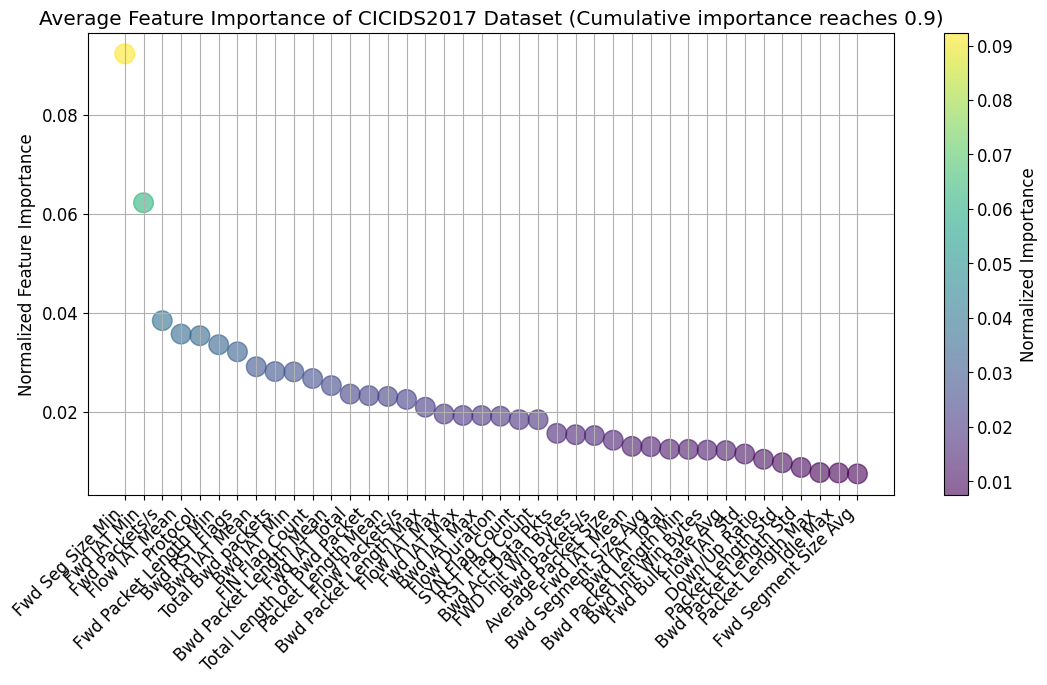

In [30]:
# Plot the feature importance of the top-3 models
plt.rcParams.update({'font.size': 12})

# Create a DataFrame for easier plotting
features = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Importance': avg_feature
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Calculate cumulative importance and filter features
features['Cumulative'] = features['Importance'].cumsum()
filtered_features = features[features['Cumulative'] <= 0.9]

# Plotting
plt.figure(figsize=(13, 6))
scatter = plt.scatter(x='Feature', y='Importance', s=200, c='Importance', cmap='viridis', alpha=0.6, data=filtered_features)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Average Feature Importance of CICIDS2017 Dataset (Cumulative importance reaches 0.9)')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.show()

In [32]:
num_features_original = len(X_train_balanced.columns)
num_features_selected = len(fs)

print(f"Features before selection: {num_features_original}")
print(f"Features after selection: {num_features_selected}")

Features before selection: 83
Features after selection: 41


# Testing

## Machine learning model training

### Training six base learners: 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

In [8]:
POST_FS_MODEL_OUTPUT = "./models/postfs"

### DT

Training time:  13.731954097747803
Prediction time per sample:  0.00010597618537993051
Accuracy of DT: 0.9999351327508255
Precision of DT: 0.9973622577262538
Recall of DT: 0.9982275463410293
F1-score of DT: 0.9977945203032088
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       0.99      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



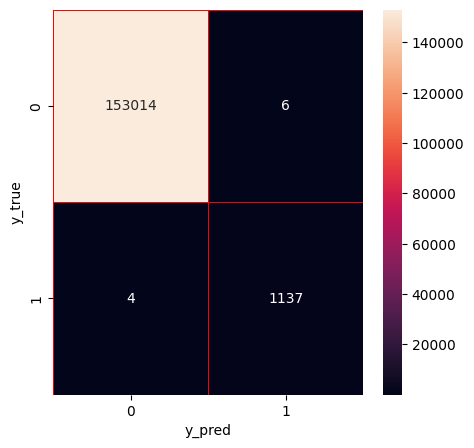

In [11]:
# %%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
# dt_scores = cross_val_f1_macro(dt, X_train_fs, y_train_balanced, 8)

# calculate the training time
start = time.time()
dt.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_val_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val_fs)*1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
# print('Cross-Validation scores: ', dt_scores)
# print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [35]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_untuned.pkl")

['./models/postfs/dt_untuned.pkl']

100%|██████████| 20/20 [03:27<00:00, 10.35s/trial, best loss: -0.9982371483649239]
Decision Tree: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 3, 'min_samples_split': 11}
Accuracy of DT: 0.9999481062006603
Precision of DT: 0.9973733773994694
Recall of DT: 0.9991039705303368
F1-score of DT: 0.9982371483649239
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       0.99      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



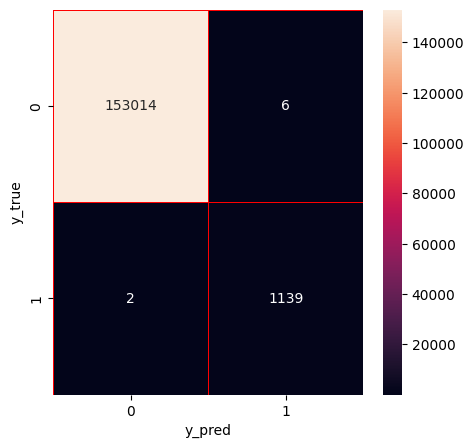

In [12]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    clf.fit(X_train_fs, y_train_balanced)
    y_pred = clf.predict(X_val_fs)
    score = f1_score(y_val, y_pred, average='macro')
    # score = cross_val_f1_macro(clf, X_train_fs, y_train_balanced, 8).mean()
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = dt.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
dt_score = dt.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [37]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt.pkl")

['./models/postfs/dt.pkl']

### RF

Training time:  27.73030662536621
Prediction time:  0.0007490077697273658 ms
Cross-Validation scores:  [0.99940476 0.99999512 0.99999512]
Mean of Cross-Validation scores:  0.9997983367212528
Accuracy of RF: 0.9999545929255778
Precision of RF: 0.9978081500931086
Recall of RF: 0.9991072380770628
F1-score of RF: 0.9984568348091433
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



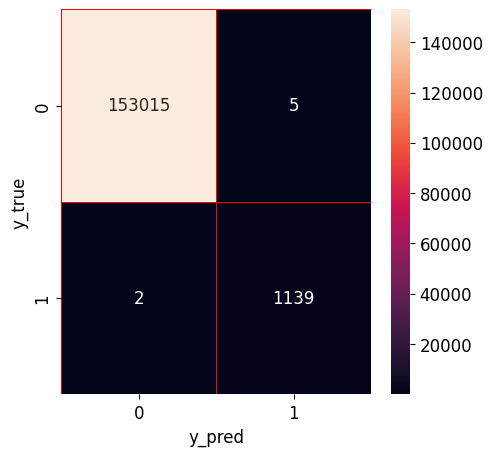

In [38]:
# %%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_f1_macro(rf, X_train_fs, y_train_balanced, 8)

# calculate the training time
start = time.time()
rf.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val_fs)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [39]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_untuned.pkl")

['./models/postfs/rf_untuned.pkl']

100%|██████████| 20/20 [32:58<00:00, 98.90s/trial, best loss: -0.9999658586195747] 
Random Forest: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 49, 'max_features': 21, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 184}
Accuracy of RF: 0.9999675663754127
Precision of RF: 0.998679979750005
Recall of RF: 0.9991137731705146
F1-score of RF: 0.9988967807341759
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



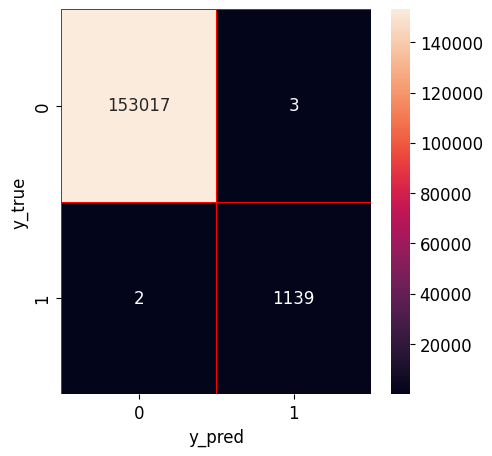

In [40]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = RandomForestClassifier(random_state=0, n_jobs=8, **params)
    score = cross_val_f1_macro(clf, X_train_fs, y_train_balanced, 8).mean()
    
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 40, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Random Forest: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, **best)
rf.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = rf.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
rf_score = rf.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [41]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf.pkl")

['./models/postfs/rf.pkl']

In [42]:
import gc
gc.collect()

10400

### ET

Training time:  12.39268684387207
Prediction time:  0.0007105866855321405 ms
Cross-Validation scores:  [0.99494504 1.         0.99999512]
Mean of Cross-Validation scores:  0.9983133871508044
Accuracy of ET: 0.9999675663754127
Precision of ET: 0.998679979750005
Recall of ET: 0.9991137731705146
F1-score of ET: 0.9988967807341759
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



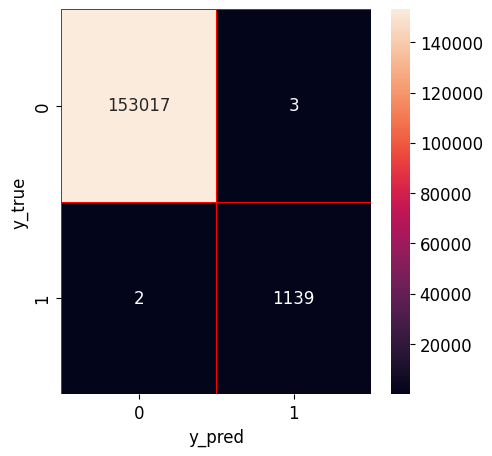

In [43]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=8)
et_scores = cross_val_f1_macro(et, X_train_fs, y_train_balanced, 8)

# calculate the training time
start = time.time()
et.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val_fs)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val_fs) * 1000, 'ms')


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [44]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_untuned.pkl")

['./models/postfs/et_untuned.pkl']

100%|██████████| 20/20 [07:26<00:00, 22.33s/trial, best loss: -0.999982117096744]
Extra Trees: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 16, 'max_features': 15, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 138}
Accuracy of ET: 0.9999740531003302
Precision of ET: 0.9991170407172405
Recall of ET: 0.9991170407172405
F1-score of ET: 0.9991170407172405
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



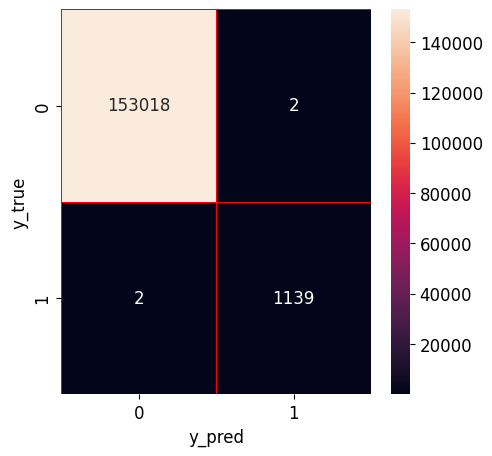

In [45]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = ExtraTreesClassifier(random_state=0, n_jobs=8, **params)
    score = cross_val_f1_macro(clf, X_train_fs, y_train_balanced, 8).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Extra Trees: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, **best)
et.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = et.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
et_score = et.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [46]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et.pkl")

['./models/postfs/et.pkl']

In [47]:
import gc
gc.collect()

10445

### XGBoost

Training time:  1.5015997886657715
Prediction time per sample:  0.00017456283924177686
Cross-Validation scores:  [0.9946848  0.99999512 0.99998537]
Mean of Cross-Validation scores:  0.9982217626675153
Accuracy of XGBoost: 0.9999675663754127
Precision of XGBoost: 0.998679979750005
Recall of XGBoost: 0.9991137731705146
F1-score of XGBoost: 0.9988967807341759
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



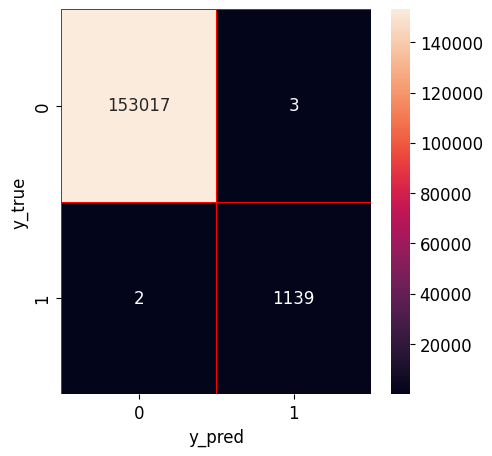

In [48]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=8)
xg_scores = cross_val_f1_macro(xg, X_train_fs, y_train_balanced, 8)

# calculate the training time
start = time.time()
xg.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val_fs) * 1000)


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [49]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_untuned.pkl")

['./models/postfs/xg_untuned.pkl']

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  5%|▌         | 1/20 [00:03<01:10,  3.72s/trial, best loss: -0.9977940893385253]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 10%|█         | 2/20 [00:08<01:13,  4.08s/trial, best loss: -0.9977940893385253]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 15%|█▌        | 3/20 [00:11<01:07,  3.98s/trial, best loss: -0.9977940893385253]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 20%|██        | 4/20 [00:14<00:54,  3.42s/trial, best loss: -0.9995087057742226]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 25%|██▌       | 5/20 [00:17<00:50,  3.35s/trial, best loss: -0.9995087057742226]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 30%|███       | 6/20 [00:20<00:44,  3.15s/trial, best loss: -0.9995087057742226]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 35%|███▌      | 7/20 [00:24<00:44,  3.46s/trial, best loss: -0.9995087057742226]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 40%|████      | 8/20 [00:27<00:39,  3.29s/trial, best loss: -0.9996583830498417]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 45%|████▌     | 9/20 [00:30<00:35,  3.19s/trial, best loss: -0.9996583830498417]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 50%|█████     | 10/20 [00:33<00:32,  3.29s/trial, best loss: -0.9996583830498417]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 55%|█████▌    | 11/20 [00:37<00:29,  3.30s/trial, best loss: -0.9996583830498417]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 60%|██████    | 12/20 [00:39<00:24,  3.09s/trial, best loss: -0.9996583830498417]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 65%|██████▌   | 13/20 [00:43<00:22,  3.22s/trial, best loss: -0.9996583830498417]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 70%|███████   | 14/20 [00:48<00:23,  3.89s/trial, best loss: -0.9996583830498417]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:48:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 75%|███████▌  | 15/20 [00:52<00:19,  3.86s/trial, best loss: -0.9996583830498417]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 80%|████████  | 16/20 [00:54<00:13,  3.39s/trial, best loss: -0.9996583830498417]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 85%|████████▌ | 17/20 [00:57<00:09,  3.04s/trial, best loss: -0.9996583830498417]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 90%|█████████ | 18/20 [01:00<00:06,  3.02s/trial, best loss: -0.9996583830498417]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 95%|█████████▌| 19/20 [01:03<00:03,  3.10s/trial, best loss: -0.9996583830498417]

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:49:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


100%|██████████| 20/20 [01:06<00:00,  3.33s/trial, best loss: -0.9996583830498417]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.42939602854925957, 'max_depth': 99, 'n_estimators': 40}
Accuracy of XGBoost: 0.9999805398252476
Precision of XGBoost: 0.9995548684580273
Recall of XGBoost: 0.9991203082639665
F1-score of XGBoost: 0.9993374923829057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



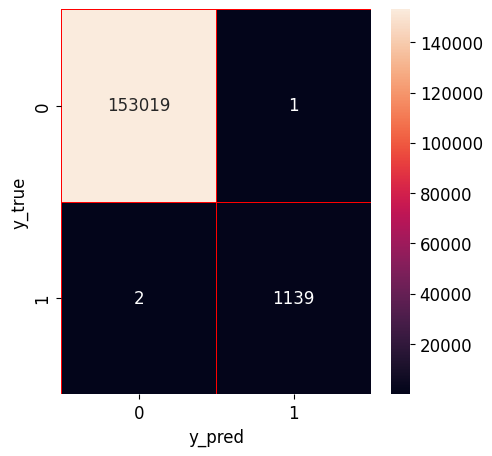

In [50]:
# Hyperparameter Optimization using BO-TPE

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate']))
    }
    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, n_jobs=8, **params)
    score = cross_val_f1_macro(clf, X_train_fs, y_train_balanced, 8).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))

print("XGBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, **best)
xg.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = xg.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
xg_score = xg.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [51]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg.pkl")

['./models/postfs/xg.pkl']

### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8784
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718
Training time:  2.2478911876678467
Prediction time per sample:  0.0007449666195843828
Accuracy of LightGBM: 0.9999805398252476
Precision of LightGBM: 0.9995548684580273
Recall of LightGBM: 0.9991203082639665
F1-score of LightGBM: 0.9993374923829057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
 

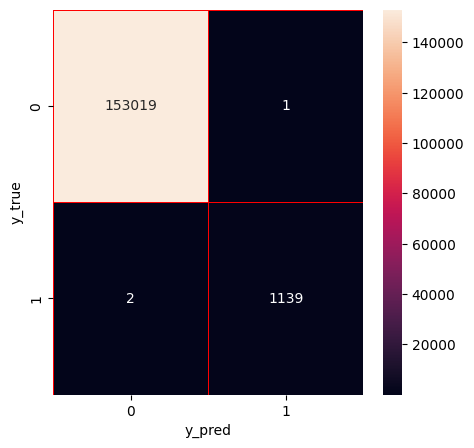

In [13]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
# lgbm_scores = cross_val_f1_macro(lgbm, X_train_fs, y_train_balanced, 8)

# calculate the training time
start = time.time()
lgbm.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val_fs) * 1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
# print('Cross-Validation scores: ', lgbm_scores)
# print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [16]:
import joblib
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_untuned.pkl")

['./models/postfs/lgbm_untuned.pkl']

In [66]:
print(lgbm.n_estimators)
print(lgbm.max_depth)
print(lgbm.learning_rate)
print(lgbm.num_leaves)
print(lgbm.min_child_samples)

100
-1
0.1
31
20


In [ ]:
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 200, 5),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 5)
}

In [ ]:
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 200, 1),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 1)
}

In [ ]:
# good for holdout
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8784                     
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines  
[LightGBM] [Info] Number of positive: 231241, number of negative: 459059         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

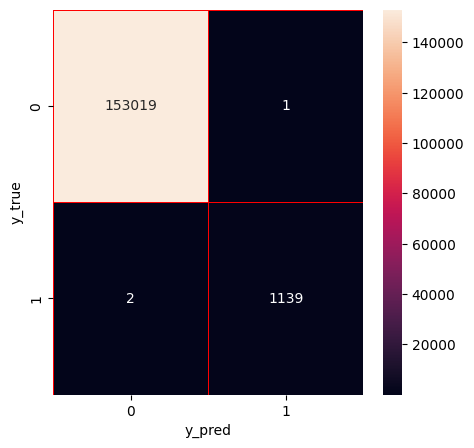

In [14]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    clf.fit(X_train_fs, y_train_balanced)
    y_pred = clf.predict(X_val_fs)
    score = f1_score(y_val, y_pred, average='macro')
    # score = cross_val_f1_macro(clf, X_train_fs, y_train_balanced, 8).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, **best)
lgbm.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = lgbm.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
lgbm_score = lgbm.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [17]:
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm.pkl")

['./models/postfs/lgbm.pkl']

### CatBoost

Training time:  25.933197736740112
Prediction time per sample:  0.00018366431975898093
Cross-Validation scores:  [0.99939013 0.99997561 0.99998049]
Mean of Cross-Validation scores:  0.9997820785995432
Accuracy of CatBoost: 0.9999610796504953
Precision of CatBoost: 0.9982436835437918
Recall of CatBoost: 0.9991105056237888
F1-score of CatBoost: 0.9986767121819253
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



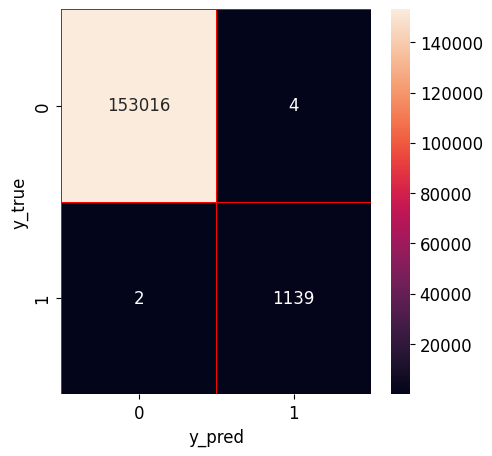

In [56]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, thread_count=8, verbose=False)
cat_scores = cross_val_f1_macro(cat, X_train_fs, y_train_balanced, 8)


# calculate the training time
start = time.time()
cat.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val_fs) * 1000)


# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [57]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_untuned.pkl")

['./models/postfs/cat_untuned.pkl']

100%|██████████| 20/20 [28:54<00:00, 86.71s/trial, best loss: -0.999791840200189] 
CatBoost: Hyperopt estimated optimum {'depth': 11, 'iterations': 800, 'learning_rate': 0.2483809133955612}
Accuracy of CatBoost: 0.9999481062006603
Precision of CatBoost: 0.9973733773994694
Recall of CatBoost: 0.9991039705303368
F1-score of CatBoost: 0.9982371483649239
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       0.99      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



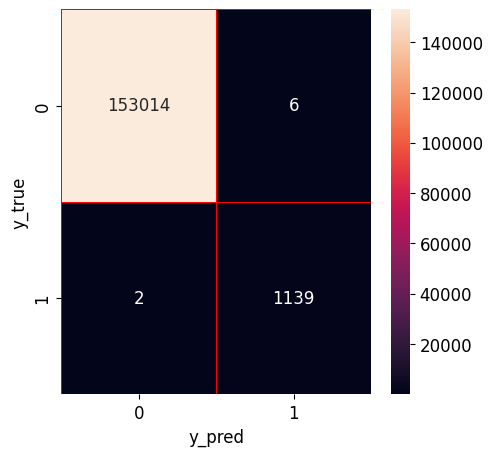

In [58]:
# Hyperparameter Optimization using BO-TPE

import catboost as cb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'iterations': int(params['iterations'])
    }
    clf = cb.CatBoostClassifier(random_state=0, verbose=False, thread_count=8, **params)
    score = cross_val_f1_macro(clf, X_train_fs, y_train_balanced, 8).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'depth': hp.quniform('depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'iterations': hp.quniform('iterations', 100, 1000, 100)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['depth'] = int(best['depth'])
best['learning_rate'] = best['learning_rate']
best['iterations'] = int(best['iterations'])

print("CatBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, **best)
cat.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = cat.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
cat_score = cat.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [59]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat.pkl")

['./models/postfs/cat.pkl']

In [ ]:
# record the results
dt_train=dt.predict(X_train_fs)
dt_val=dt.predict(X_val_fs)
dt_prob_train=dt.predict_proba(X_train_fs)
dt_prob_val=dt.predict_proba(X_val_fs)

rf_train=rf.predict(X_train_fs)
rf_val=rf.predict(X_val_fs)
rf_prob_train=rf.predict_proba(X_train_fs)
rf_prob_val=rf.predict_proba(X_val_fs)

et_train=et.predict(X_train_fs)
et_val=et.predict(X_val_fs)
et_prob_train=et.predict_proba(X_train_fs)
et_prob_val=et.predict_proba(X_val_fs)

xg_train=xg.predict(X_train_fs)
xg_val=xg.predict(X_val_fs)
xg_prob_train=xg.predict_proba(X_train_fs)
xg_prob_val=xg.predict_proba(X_val_fs)

lgbm_train=lgbm.predict(X_train_fs)
lgbm_val=lgbm.predict(X_val_fs)
lgbm_prob_train=lgbm.predict_proba(X_train_fs)
lgbm_prob_val=lgbm.predict_proba(X_val_fs)

cat_train=cat.predict(X_train_fs)
cat_val=cat.predict(X_val_fs)
cat_prob_train=cat.predict_proba(X_train_fs)
cat_prob_val=cat.predict_proba(X_val_fs)

: 

## Model selection

In [ ]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]



: 

In [ ]:
top_3_models

['et', 'rf', 'cat']

: 

In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)


dt_val=dt_val.reshape(-1, 1)
et_val=et_val.reshape(-1, 1)
rf_val=rf_val.reshape(-1, 1)
xg_val=xg_val.reshape(-1, 1)
lgbm_val=lgbm_val.reshape(-1, 1)
cat_val=cat_val.reshape(-1, 1)

: 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 613556, number of used features: 3
[LightGBM] [Info] Start training from score -0.522428
[LightGBM] [Info] Start training from score -1.860941
[LightGBM] [Info] Start training from score -1.380729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

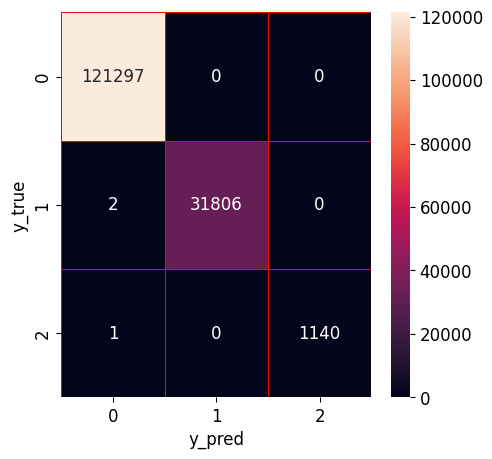

: 

In [ ]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_val_predictions = [globals()[model.lower() + '_val'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train_balanced = np.concatenate(top_3_train_predictions, axis=1)
x_val = np.concatenate(top_3_val_predictions, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [ ]:
joblib.dump(stk, f"{POST_FS_MODEL_OUTPUT}/stk1.pkl")

['./models2/postfs/stk1.pkl']

: 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1659
[LightGBM] [Info] Number of data points in the train set: 613556, number of used features: 9
[LightGBM] [Info] Start training from score -0.522428
[LightGBM] [Info] Start training from score -1.860941
[LightGBM] [Info] Start training from score -1.380729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

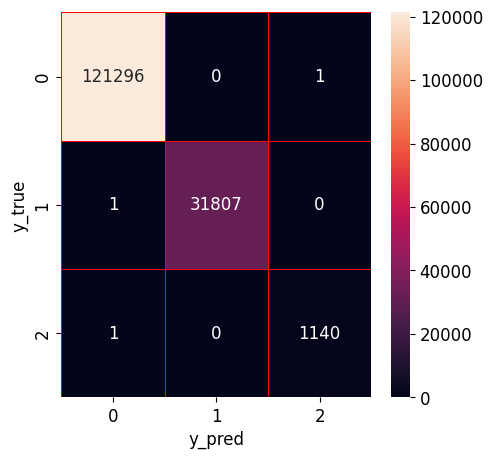

: 

In [ ]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_val_proba = [globals()[model.lower() + '_prob_val'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train_balanced = np.concatenate(top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_val_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
joblib.dump(stk, f"{POST_FS_MODEL_OUTPUT}/stk2.pkl")

['./models2/postfs/stk2.pkl']

: 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 613556, number of used features: 12
[LightGBM] [Info] Start training from score -0.522428
[LightGBM] [Info] Start training from score -1.860941
[LightGBM] [Info] Start training from score -1.380729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

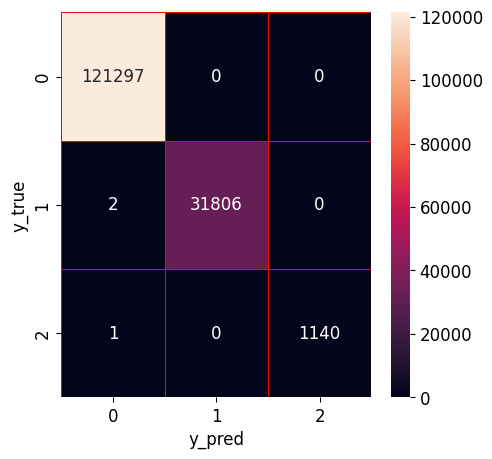

: 

In [ ]:
# Ensemble method 3: hybrid stacking
# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_val_predictions = [globals()[model.lower() + '_val'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_val_proba = [globals()[model.lower() + '_prob_val'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train_balanced = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_val_predictions + top_3_val_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# PS: the hyperparameter optimization process is the same as the previous steps

In [ ]:
joblib.dump(stk, f"{POST_FS_MODEL_OUTPUT}/stk3.pkl")

['./models2/postfs/stk3.pkl']

: 

# Final Test

In [ ]:
df_test = pd.read_csv('../../datasets/output/test_final.csv', parse_dates=['Timestamp'])
df_test

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index
0,731aa56d-0988-45de-810c-ab8d12983741,192.168.10.14,51104,93.184.216.180,443,6,2017-07-05 13:05:56.267121,85742.0,10,6,...,0.0,0.0,0,0,0,0,0,85742,Benign,748588
1,b6008226-1555-44cc-bf70-a94cb1f462fa,192.168.10.51,47817,162.213.33.48,443,6,2017-07-05 13:05:56.893194,1038445.0,10,12,...,0.0,0.0,0,0,0,0,0,1038445,Benign,499043
2,6388e7aa-19d1-4eff-a636-8e591102bebd,192.168.10.14,51114,178.255.83.1,80,6,2017-07-05 13:05:57.976332,70672.0,5,5,...,0.0,0.0,0,0,1,0,1,70672,Benign,855901
3,e7269a43-9ca3-4a71-ae08-de00db473d27,192.168.10.14,51122,63.251.85.32,443,6,2017-07-05 13:05:58.340753,217279.0,9,11,...,0.0,0.0,0,0,1,0,1,217279,Benign,936128
4,9a074a5e-7346-468f-b7fc-0b03c9f62df1,192.168.10.14,51121,63.251.85.32,443,6,2017-07-05 13:05:58.340662,219470.0,8,8,...,0.0,0.0,0,0,1,0,1,219470,Benign,708939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153691,a2ff9bf2-a9d1-4c20-af0e-1fd25d49e7aa,192.168.10.50,13290,192.168.10.3,53,17,2017-07-07 19:19:22.247125,188.0,2,2,...,0.0,0.0,0,0,0,0,0,188,Benign,782155
153692,440ba4c4-8b02-42ce-a0cd-b38e96dda6cc,192.168.10.50,60990,192.168.10.3,53,17,2017-07-07 19:19:22.247401,176.0,2,2,...,0.0,0.0,0,0,0,0,0,176,Benign,578218
153693,23bda82f-329f-4408-913c-d7a079cbaf9e,192.168.10.50,61663,192.168.10.3,53,17,2017-07-07 19:19:22.247440,188.0,2,2,...,0.0,0.0,0,0,0,0,0,188,Benign,1007490
153694,26ba35bf-ba1b-4a3c-89b9-7c9bb4c50883,192.168.10.50,55577,192.168.10.3,53,17,2017-07-07 19:19:22.247120,150.0,2,2,...,0.0,0.0,0,0,0,0,0,150,Benign,626458


: 

In [ ]:
df_test = df_test.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Old Index', 'Fwd TCP Retrans. Count', 'Bwd TCP Retrans. Count', 'Total TCP Retrans. Count', 'Total Connection Flow Time'], axis=1)

: 

In [ ]:
df_test['Label'].value_counts()

Label
Benign       120750
Portscan      31808
Slowloris      1138
Name: count, dtype: int64

: 

In [ ]:
df_test['Label'] = df_test['Label'].map({
    "Slowloris": "Slowloris",
    "Portscan": "Not Slowloris",
    "Benign": "Not Slowloris"
})

: 

In [ ]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

array([0, 1])

: 

In [ ]:
X_test_fs = df_test.drop('Label', axis=1)
y_test = labelencoder.transform(df_test['Label'])

: 

In [ ]:
X_test_fs = df_test.drop('Label', axis=1)[fs]
y_test = labelencoder.transform(df_test['Label'])

NameError: name 'fs' is not defined

: 

In [ ]:
# record the results
dt_test_real=dt.predict(X_test_fs)
dt_prob_test_real=dt.predict_proba(X_test_fs)

rf_test_real=rf.predict(X_test_fs)
rf_prob_test_real=rf.predict_proba(X_test_fs)

et_test_real=et.predict(X_test_fs)
et_prob_test_real=et.predict_proba(X_test_fs)

xg_test_real=xg.predict(X_test_fs)
xg_prob_test_real=xg.predict_proba(X_test_fs)

lgbm_test_real=lgbm.predict(X_test_fs)
lgbm_prob_test_real=lgbm.predict_proba(X_test_fs)

cat_test_real=cat.predict(X_test_fs)
cat_prob_test_real=cat.predict_proba(X_test_fs)

: 

In [ ]:
dt_test_real=dt_test_real.reshape(-1, 1)
rf_test_real=rf_test_real.reshape(-1, 1)
et_test_real=et_test_real.reshape(-1, 1)
xg_test_real=xg_test_real.reshape(-1, 1)
lgbm_test_real=lgbm_test_real.reshape(-1, 1)
cat_test_real=cat_test_real.reshape(-1, 1)

: 

Prediction time per sample:  0.0006497641565798224 ms
Accuracy of DT: 0.9977227774307724
Precision of DT: 0.992699956118787
Recall of DT: 0.8505823398152804
F1-score of DT: 0.9094990097509024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    152558
           1       0.99      0.70      0.82      1138

    accuracy                           1.00    153696
   macro avg       0.99      0.85      0.91    153696
weighted avg       1.00      1.00      1.00    153696



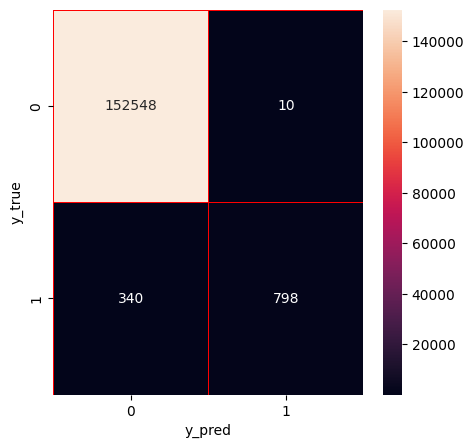

: 

In [ ]:
# Decision Tree

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
dt_score = dt.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.002081739278752954 ms
Accuracy of RF: 0.9969485614646905
Precision of RF: 0.9969567247808099
Recall of RF: 0.9969485614646905
F1-score of RF: 0.9966678153283832
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.64      0.78      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.88      0.93    153698
weighted avg       1.00      1.00      1.00    153698



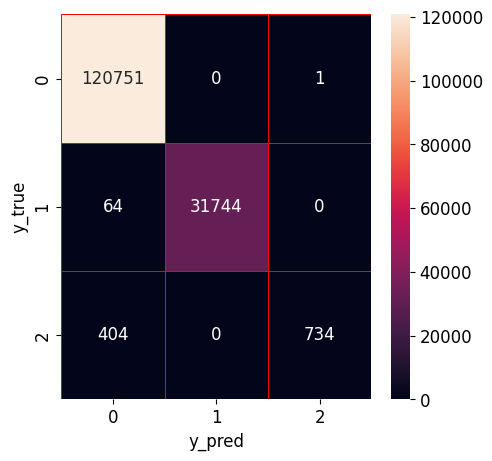

: 

In [ ]:
# Random Forest

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
rf_score = rf.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0035705702168550377 ms
Accuracy of ET: 0.9972868872724434
Precision of ET: 0.9972932317197166
Recall of ET: 0.9972868872724434
F1-score of ET: 0.9970770226420791
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.69      0.82      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.90      0.94    153698
weighted avg       1.00      1.00      1.00    153698



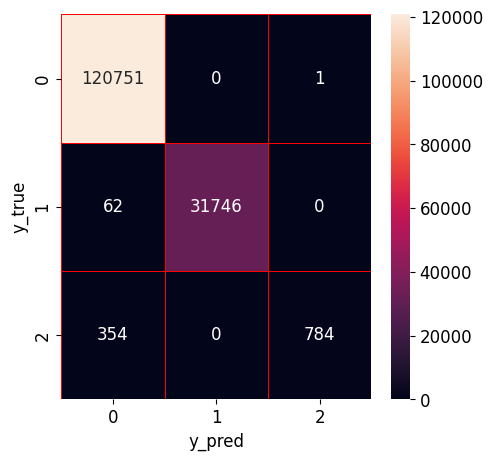

: 

In [ ]:
# Extra Trees

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
et_score = et.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00047739869788246224 ms
Accuracy of XG: 0.997273874741376
Precision of XG: 0.9972833014728824
Recall of XG: 0.997273874741376
F1-score of XG: 0.9970599842786215
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.69      0.81      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.89      0.94    153698
weighted avg       1.00      1.00      1.00    153698



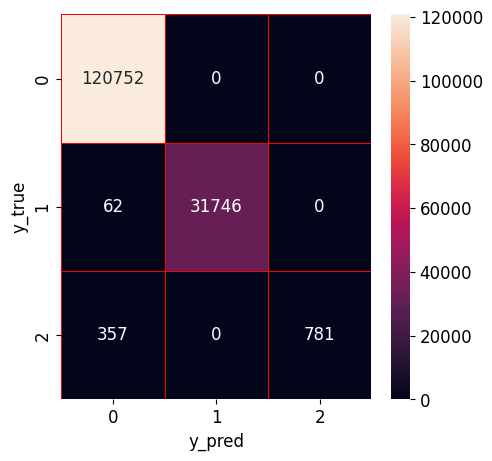

: 

In [ ]:
# XGBoost

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
xg_score = xg.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of XG: ' + str(xg_score))
print('Precision of XG: ' + str(precision))
print('Recall of XG: ' + str(recall))
print('F1-score of XG: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0008796689710421116 ms
Accuracy of LGBM: 0.9974170125831175
Precision of LGBM: 0.9974254769204585
Recall of LGBM: 0.9974170125831175
F1-score of LGBM: 0.9972308453083975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.71      0.83      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.90      0.94    153698
weighted avg       1.00      1.00      1.00    153698



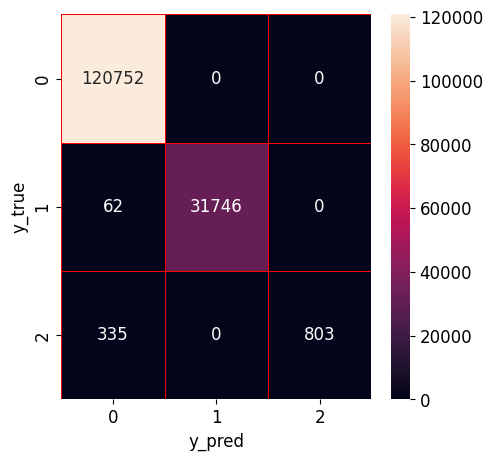

: 

In [ ]:
# LightGBM

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
lgbm_score = lgbm.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of LGBM: ' + str(lgbm_score))
print('Precision of LGBM: ' + str(precision))
print('Recall of LGBM: ' + str(recall))
print('F1-score of LGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0003134601358076822 ms
Accuracy of Cat: 0.9973649624588479
Precision of Cat: 0.9973737707836179
Recall of Cat: 0.9973649624588479
F1-score of Cat: 0.9971702228595163
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.70      0.82      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.90      0.94    153698
weighted avg       1.00      1.00      1.00    153698



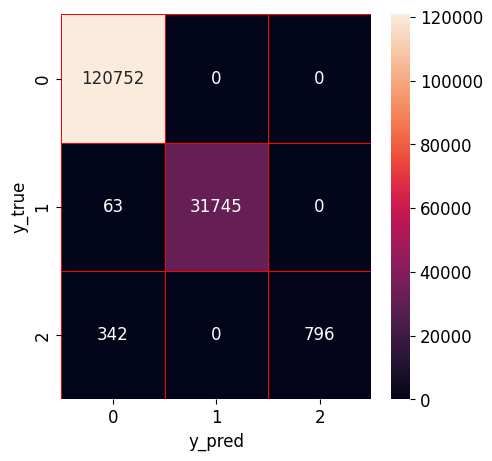

: 

In [ ]:
# CatBoost

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
cat_score = cat.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of Cat: ' + str(cat_score))
print('Precision of Cat: ' + str(precision))
print('Recall of Cat: ' + str(recall))
print('F1-score of Cat: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
stk1 = joblib.load(f"{POST_FS_MODEL_OUTPUT}/stk1.pkl")
stk2 = joblib.load(f"{POST_FS_MODEL_OUTPUT}/stk2.pkl")
stk3 = joblib.load(f"{POST_FS_MODEL_OUTPUT}/stk3.pkl")

: 

Accuracy of Stacking: 0.9973649624588479
Precision of Stacking: 0.9973737707836179
Recall of Stacking: 0.9973649624588479
F1-score of Stacking: 0.9971702228595163
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.70      0.82      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.90      0.94    153698
weighted avg       1.00      1.00      1.00    153698



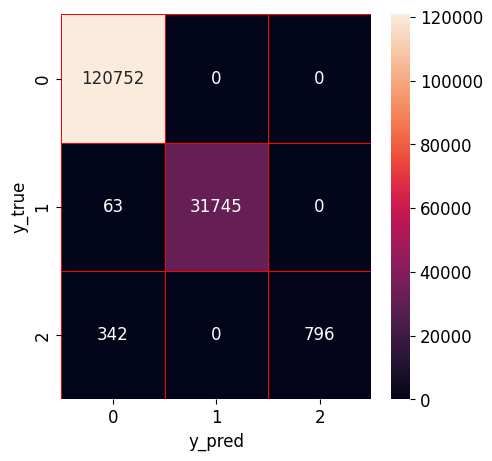

: 

In [ ]:
# Ensemble method 1: traditional stacking
top_3_test_real_predictions = [globals()[model.lower() + '_test_real'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_test_real = np.concatenate(top_3_test_real_predictions, axis=1)

y_predict = stk1.predict(x_test_real)
y_true = y_test

stk1_score = accuracy_score(y_true, y_predict)
print('Accuracy of Stacking: '+ str(stk1_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Accuracy of Stacking: 0.9974430376452523
Precision of Stacking: 0.9974460047980515
Recall of Stacking: 0.9974430376452523
F1-score of Stacking: 0.99726659528209
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.71      0.83      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.90      0.94    153698
weighted avg       1.00      1.00      1.00    153698



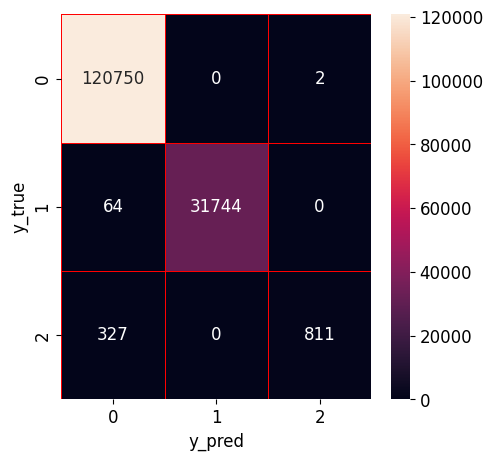

: 

In [ ]:
# Ensemble method 2: confidence-based stacking
top_3_test_real_proba = [globals()[model.lower() + '_prob_test_real'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_test_real = np.concatenate(top_3_test_real_proba, axis=1)

y_predict = stk2.predict(x_test_real)
y_true = y_test

stk2_score=accuracy_score(y_true, y_predict)
print('Accuracy of Stacking: '+ str(stk2_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Accuracy of Stacking: 0.9973649624588479
Precision of Stacking: 0.9973737707836179
Recall of Stacking: 0.9973649624588479
F1-score of Stacking: 0.9971702228595163
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.70      0.82      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.90      0.94    153698
weighted avg       1.00      1.00      1.00    153698



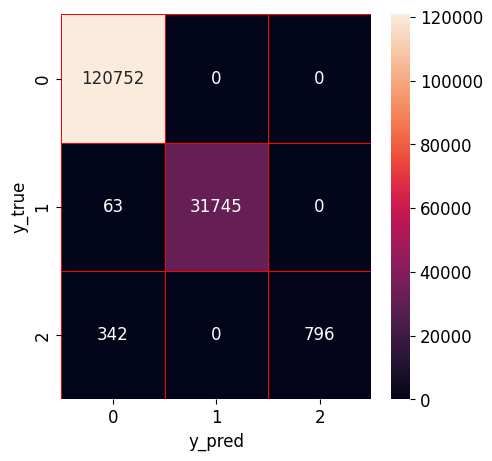

: 

In [ ]:
# Ensemble method 1: traditional stacking
top_3_test_real_predictions = [globals()[model.lower() + '_test_real'] for model in top_3_models]
top_3_test_real_proba = [globals()[model.lower() + '_prob_test_real'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_test_real = np.concatenate(top_3_test_real_predictions + top_3_test_real_proba, axis=1)

y_predict=stk3.predict(x_test_real)
y_true=y_test

stk3_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk3_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()